# GB Carbon Intensity Time-Series

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

import dask
import dask.dataframe as dd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
from tqdm import tqdm
import FEAutils as hlp
from dotenv import load_dotenv

<br>

### Inputs

In [2]:
load_dotenv('../.env')

datahub_dir = os.getenv('DATAHUB_DIR')

<br>

### Data Loading

In [4]:
ids_fp = 'https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/shiro/data/dictionary/ids.csv'

df_ids = pd.read_csv(ids_fp).set_index('dictionary_id')

df_ids.head(2)

,gppd_idnr,esail_id,name,sett_bmu_id,ngc_bmu_id,4c_offshore_id,windpowernet_id,wikidata_id,wikipedia_id,power_technology_id,eutl_id,eic_id,cfd_id,jrc_id,iaea_id,old_repd_id,new_repd_id
dictionary_id,,,,,,,,,,,,,,,,,
10000,NaN,MARK,Rothes Bio-Plant CHP,"E_MARK-1, E_MARK-2","MARK-1, MARK-2",NaN,NaN,NaN,NaN,NaN,NaN,48W000000MARK-1D,NaN,NaN,NaN,NaN,NaN
10001,"GBR1000377, GBR1000369",DIDC,Didcot,"T_DIDC1, T_DIDC2, T_DIDC4, T_DIDC3, T_DIDC1G, ...","DIDC1, DIDC2, DIDC4, DIDC3, DIDC1G, DIDC2G, DI...",NaN,NaN,NaN,NaN,NaN,97165,"48W00000DIDC01G1, 48W00000DIDC02GZ, 48W00000DI...",NaN,NaN,NaN,NaN,NaN


In [5]:
df_site_carbon_intensities = pd.read_csv('../data/plant_carbon_intensity.csv').set_index(['dictionary_id', 'year'])
dictionary_ids = df_site_carbon_intensities.index.get_level_values(0).unique()

df_site_carbon_intensities.head()

carbon_intensity_gco2_per_kwh
dictionary_id year                               
10002         2016                         856.56
              2017                         849.48
              2018                         933.70
              2019                         918.49
10003         2016                         954.14

In [6]:
@dask.delayed
def read_B1610_file(filename, columns):
    df_B1610_week = pd.read_csv(filename)
    cols_to_add = list(set(columns) - set(df_B1610_week.columns))
    df_B1610_week[cols_to_add] = np.NaN
    df_B1610_week = df_B1610_week[columns]
    
    return df_B1610_week

def get_B1610_columns(static_dir, source_name='bmrs', stream='B1610'):
    B1610_files = [f for f in os.listdir(f'{static_dir}/{source_name}/{stream}') if '.csv' in f]

    columns = []

    for B1610_file in tqdm(B1610_files):
        df_B1610_week = pd.read_csv(f'{static_dir}/{source_name}/{stream}/{B1610_file}')
        columns += list(df_B1610_week.columns)

    columns = ['datetime'] + sorted(list(set(columns)-set(['datetime'])))

    return columns

def load_B1610_dask_stream_df(static_dir, source_name, stream, dt_col='datetime'):
    # Identifying columns
    columns = get_B1610_columns(static_dir)
    
    # Loading data
    B1610_files = [f for f in os.listdir(f'{static_dir}/{source_name}/{stream}') if '.csv' in f]
    df_B1610 = dd.from_delayed([read_B1610_file(f'{static_dir}/{source_name}/{stream}/{B1610_file}', columns) for B1610_file in B1610_files])

    # Formatting date index
    if dt_col is not None:
        df_B1610[dt_col] = df_B1610[dt_col].map(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d %H:%M:%S', errors='coerce', utc=True))
        df_B1610 = df_B1610.set_index(dt_col)
        
    df_B1610 = df_B1610.copy().compute()
    
    return df_B1610

In [7]:
%%time

source_name = 'bmrs'
stream = 'B1610'

df_B1610 = load_B1610_dask_stream_df(datahub_dir, source_name, stream)

df_B1610.head()

100%|████████████████████████████████████████████████████████████████████████████████| 288/288 [00:09<00:00, 30.30it/s]
C:\Users\Ayrto\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:3645: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value
C:\Users\Ayrto\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:3645: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value


Wall time: 1min 16s


,ABRBO-1,ABRTW-1,ABTH7,ABTH7G,ABTH8,ABTH8G,ABTH9,ABTH9G,ACHRW-1,AKGLW-2,...,WILCT-1,WLNYO-2,WLNYO-3,WLNYO-4,WLNYW-1,WTMSO-1,WYLF-1,WYLF-2,WYLF-3,WYLF-4
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-04 23:00:00+00:00,NaN,NaN,421.692,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,132.90,NaN,NaN,95.602,9.858,227.380,212.410,NaN,NaN
2015-10-04 23:30:00+00:00,NaN,NaN,425.096,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,143.02,NaN,NaN,107.324,14.890,227.470,212.530,NaN,NaN
2015-10-05 00:00:00+00:00,NaN,NaN,423.292,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,158.98,NaN,NaN,118.342,23.074,227.666,212.720,NaN,NaN
2015-10-05 00:30:00+00:00,NaN,NaN,431.148,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,163.18,NaN,NaN,140.900,36.890,227.826,212.844,NaN,NaN
2015-10-05 01:00:00+00:00,NaN,NaN,418.772,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,160.86,NaN,NaN,148.838,47.772,228.054,213.086,NaN,NaN


In [8]:
def construct_site_output_df(df_B1610, df_ids, dictionary_ids):
    df_site_output = pd.DataFrame(index=df_B1610.index, columns=dictionary_ids)

    for dictionary_id, ngc_bmu_ids in tqdm(
        df_ids
        .loc[dictionary_ids, 'ngc_bmu_id']
        .str.split(', ')
        .to_dict()
        .items()
    ):
        ngc_bmu_ids = list(set(df_B1610.columns).intersection(ngc_bmu_ids))
        
        if len(ngc_bmu_ids) > 0:
            df_site_output[dictionary_id] = df_B1610[ngc_bmu_ids].sum(axis=1)
            
    return df_site_output

In [9]:
df_site_output = construct_site_output_df(df_B1610, df_ids, dictionary_ids)

df_site_output.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.43it/s]


dictionary_id,10002,10003,10004,10005,10006,10007,10009,10010,10011,10012,...,10057,10058,10059,10067,10068,10070,10091,10097,10101,10104
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-04 23:00:00+00:00,421.692,306.128,1712.068,0.0,431.558,0.0,1102.65,261.304,0.0,247.736,...,0.0,1130.7,0.0,230.0,142.12,444.8,0.0,0.0,0.0,0.0
2015-10-04 23:30:00+00:00,425.096,301.646,1580.588,0.0,431.794,0.0,966.70,260.428,0.0,248.864,...,0.0,1141.0,0.0,229.9,142.10,307.7,0.0,0.0,0.0,0.0
2015-10-05 00:00:00+00:00,423.292,406.684,1692.684,0.0,461.178,0.0,947.55,258.540,0.0,249.136,...,0.0,1063.8,0.0,230.0,142.02,235.4,0.0,0.0,0.0,0.0
2015-10-05 00:30:00+00:00,431.148,497.890,1817.112,0.0,463.120,0.0,959.70,259.374,0.0,279.384,...,0.0,1160.3,0.0,229.9,142.12,231.5,0.0,0.0,0.0,0.0
2015-10-05 01:00:00+00:00,418.772,478.622,1800.868,0.0,441.080,0.0,946.02,259.592,0.0,248.868,...,0.0,1023.2,0.0,229.9,142.12,231.7,0.0,0.0,0.0,0.0


In [15]:
# I also need to include the output from embedded plants - use BMRS wind adjustment and EI solar

<AxesSubplot:xlabel='datetime'>

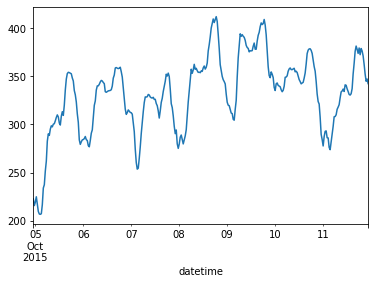

In [16]:
s_total_output = df_B1610.sum(axis=1) 
s_site_avg_carbon_intensities = df_site_carbon_intensities.groupby(df_site_carbon_intensities.index.get_level_values(0)).mean()['carbon_intensity_gco2_per_kwh']
s_carbon_intensity_ts = df_site_output.multiply(s_site_avg_carbon_intensities).sum(axis=1)/s_total_output
s_carbon_intensity_ts.name = 'gb_carbon_intensity_gco2_per_kwh'

s_carbon_intensity_ts.iloc[:48*7].plot()

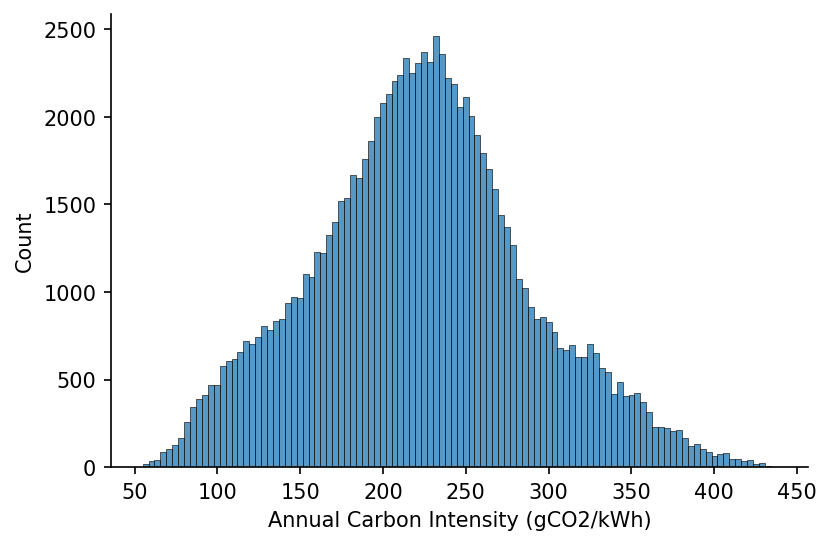

In [17]:
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_carbon_intensity_ts, ax=ax)

ax.set_xlabel('Annual Carbon Intensity (gCO2/kWh)')
hlp.hide_spines(ax)

In [19]:
s_carbon_intensity_ts.to_csv('../data/gb_transmission_carbon_intensity.csv')

In [ ]:
# should add an estimate that uses average fuel-type intensities from EI

In [68]:
fuel_to_ei_carbon_intensities = {
    'wind': 0,
    'solar': 0,
    'coal': 937,
    'ps': 0,
    'npshyd': 0,
    'oil': 985,
    'diesel': 985,
    'recip': 651,
    'ocgt': 651,
    'ccgt': 394,
    'nuclear': 0,
    'biomass': 121,
    'mixed': np.nan,
    'other': np.nan,
}

ids = df_site_carbon_intensities.index.get_level_values(0).unique()
s_site_fuel_type_mod = pd.read_csv('../data/site_fuel_types.csv').set_index('Unnamed: 0')['0']
s_ei_site_carbon_intensities = s_site_fuel_type_mod.map(fuel_to_ei_carbon_intensities)
s_ei_fuel_carbon_intensity_ts = df_site_output.multiply(s_ei_site_carbon_intensities.loc[df_site_output.columns]).sum(axis=1)/df_site_output[list(s_ei_site_carbon_intensities.loc[df_site_output.columns].isnull().replace(True, np.nan).dropna().index)].sum(axis=1)

s_ei_fuel_carbon_intensity_ts.head()

datetime
2015-10-04 23:00:00+00:00    605.160190
2015-10-04 23:30:00+00:00    601.959904
2015-10-05 00:00:00+00:00    613.575716
2015-10-05 00:30:00+00:00    616.542732
2015-10-05 01:00:00+00:00    618.285988
dtype: float64

Text(0.5, 0, 'Electric Insights Carbon Intensity (gCO2/kWh)')

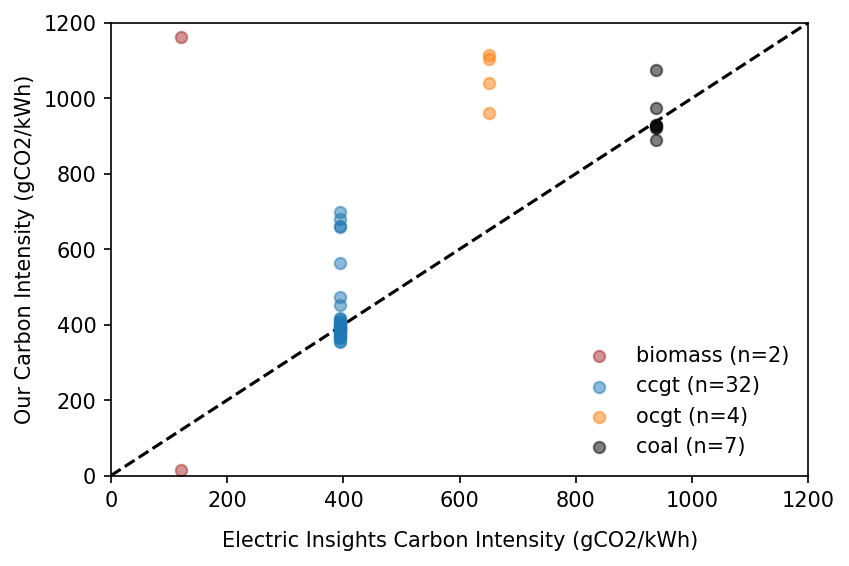

In [118]:
common_idxs = s_site_avg_carbon_intensities.index.intersection(s_ei_site_carbon_intensities.dropna().index)

s_ei_site_carbon_intensities_ = s_ei_site_carbon_intensities.loc[common_idxs].copy()
s_site_avg_carbon_intensities_ = s_site_avg_carbon_intensities.loc[common_idxs].copy()

fuel_colour_map = {
    'biomass': 'brown',  
    'ccgt': 'C0', 
    'ocgt': 'C1',
    'coal': 'black',
}

# Plotting
fig, ax = plt.subplots(dpi=150)

for fuel_type in fuel_colour_map.keys():
    idxs = s_ei_site_carbon_intensities_.index[s_ei_site_carbon_intensities_.index.get_level_values(0).isin(s_site_fuel_type_mod.index[s_site_fuel_type_mod==fuel_type.lower()])]
    
    if idxs.size > 0:
        ax.scatter(s_ei_site_carbon_intensities_.loc[idxs], s_site_avg_carbon_intensities_.loc[idxs], c=fuel_colour_map[fuel_type], label=f'{fuel_type} (n={idxs.size})', s=30, alpha=0.5)

ax.plot([0, 1200], [0, 1200], 'k--', zorder=0)
ax.set_xlim(0, 1200)
ax.set_ylim(0, 1200)
ax.legend(frameon=False)
ax.set_ylabel('Our Carbon Intensity (gCO2/kWh)')
ax.set_xlabel('Electric Insights Carbon Intensity (gCO2/kWh)', labelpad=10)

<AxesSubplot:xlabel='datetime'>

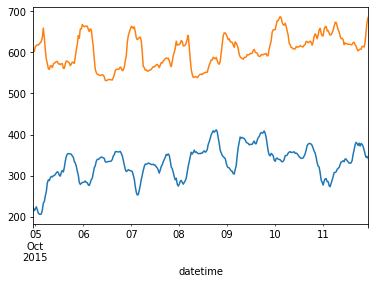

In [69]:
s_carbon_intensity_ts.iloc[:48*7].plot()
s_ei_fuel_carbon_intensity_ts.iloc[:48*7].plot()